# Model V1: Baseline Experiment (Week 3)

This notebook is our "laboratory" for building and testing our first model.
The goal is to create a baseline `Pipeline` that handles missing values and categorical data, train a `RandomForestRegressor`, and get our first R² and RMSE scores.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('../data/features/olx_cars_features_v1.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3375 entries, 0 to 3374
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   log_price        3375 non-null   float64
 1   car_age          3375 non-null   float64
 2   km_per_year      3375 non-null   float64
 3   motor_clean      3257 non-null   float64
 4   marca            3375 non-null   object 
 5   state_clean      3375 non-null   object 
 6   câmbio           3305 non-null   object 
 7   combustível      3304 non-null   object 
 8   bancos_de_couro  3375 non-null   bool   
 9   teto_solar       3375 non-null   bool   
 10  tracao_4x4       3375 non-null   bool   
 11  blindado         3375 non-null   bool   
 12  unico_dono       3375 non-null   bool   
dtypes: bool(5), float64(4), object(4)
memory usage: 227.5+ KB


### Separating The Target (y) and Features (X)

Before we do anything else, we must separate our target variable (what we want to predict) from our features (the "clues" we use to predict).

* **y (Target):** `log_price`
* **X (Features):** Everything else.

In [4]:
# 1. Define the target (y)
y = df['log_price']

# 2. Define the features (X)
X = df.drop('log_price', axis=1)

print("Target (y) shape:", y.shape)
print("Features (X) shape:", X.shape)

Target (y) shape: (3375,)
Features (X) shape: (3375, 12)


### The "Wall of Fire" - Train-Test Split

This is the most critical step. We split our data into a "training" set (what the model learns from) and a "testing" set (what we use to evaluate it).

By doing this *before* preprocessing (like filling NaNs), we guarantee that our model never gets any information about the test set. This prevents **Data Leakage** and ensures our evaluation is honest.

In [5]:
# Import the function
from sklearn.model_selection import train_test_split

# Split the data!
# test_size=0.2 means 20% of data goes to testing, 80% to training.
# random_state=42 ensures we get the same "random" split every time we run this.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (2700, 12)
X_test shape: (675, 12)


### Building the Preprocessing "Recipe"

Now we define the "recipes" to fix our data. We have 3 types of columns in `X`:

1.  **Numeric (`float64`):** `car_age`, `km_per_year`, `motor_clean`.
    * **Recipe:** Must fill the `NaNs` in `motor_clean`. We'll use the **median** (the middle value).
2.  **Categorical (`object`):** `marca`, `state_clean`, `câmbio`, `combustível`.
    * **Recipe:** Must fill the `NaNs` (using the **most_frequent** value) AND then convert the text ("VW", "SP") into numbers (0s and 1s) using **One-Hot Encoding**.
3.  **Boolean (`bool`):** `bancos_de_couro`, `teto_solar`, etc.
    * **Recipe:** Nothing! They are already `True/False` (which Python treats as 1/0). They are perfect.

We'll use `ColumnTransformer` to apply the right recipe to the right columns.

In [6]:
# --- 1. Identify the columns for each "recipe" ---

# Recipe 1: Numeric Columns
numeric_features = ['car_age', 'km_per_year', 'motor_clean']

# Recipe 2: Categorical Columns
categorical_features = ['marca', 'state_clean', 'câmbio', 'combustível']

# Recipe 3: Boolean Columns
boolean_features = ['bancos_de_couro', 'teto_solar', 'tracao_4x4', 'blindado', 'unico_dono']

# --- 2. Define the "recipes" (Pipelines) ---

# Recipe for numeric data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
    # (We could add a 'scaler' here later, but RandomForest doesn't need it)
])

# Recipe for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Fills NaNs with the most common value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))   # Converts text to 0s and 1s
])

# --- 3. Create the ColumnTransformer ("The Brain") ---
# This applies the right recipe to the right columns.
# For the boolean columns, we just 'passthrough' (let them pass untouched).

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('bool', 'passthrough', boolean_features)
    ])

### Creating the Final Model Pipeline

This is it. We now create the final `Pipeline` object.

It will chain together our `preprocessor` (from Act 4) and our actual model (the `RandomForestRegressor`). When we call `.fit()` on this pipeline, it will automatically handle all the preprocessing *and* model training in one go.


In [7]:
# This chains the "brain" (preprocessor) with the "brawn" (model)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), # Step 1: Clean the data
    ('model', RandomForestRegressor( # Step 2: Train the model
        n_estimators=100,         # How many "trees" to build. 100 is a good default.
        random_state=42,          # For reproducibility
        n_jobs=-1                 # -1 means "use all my CPU cores" (MUCH faster)
    ))
])

### Train the Model!

This is the moment of truth. We call `.fit()` on our pipeline, using our training data (`X_train`, `y_train`).

In [8]:
model_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Evaluation (Did it work?)

The model is trained. But is it any good?

We now use our **unseen test data** (`X_test`, `y_test`) to get an honest score. We'll look at two metrics:

1.  **R² (R-squared):** "Percentage of price variance explained." 1.0 is perfect. 0.80+ is good, 0.90+ is great.
2.  **RMSE (Root Mean Squared Error):** "How many 'log_price' units is our model off by, on average?" Lower is better.

In [9]:
# 1. Get predictions from the test data
# (The pipeline automatically preprocesses X_test using the rules it learned from X_train)
y_pred = model_pipeline.predict(X_test)

# 2. Calculate the metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test Set R-squared (R²): {r2:.4f}")
print(f"Test Set Root Mean Squared Error (RMSE): {rmse:.4f}")

Test Set R-squared (R²): 0.8493
Test Set Root Mean Squared Error (RMSE): 0.2291


### "What did you learn?" (Feature Importance)

The model is trained. Now we ask it *what* it learned.

We'll extract the `feature_importances_` from the `RandomForestRegressor`. This tells us which features the model found most predictive. This is the *payoff* for all our EDA work.

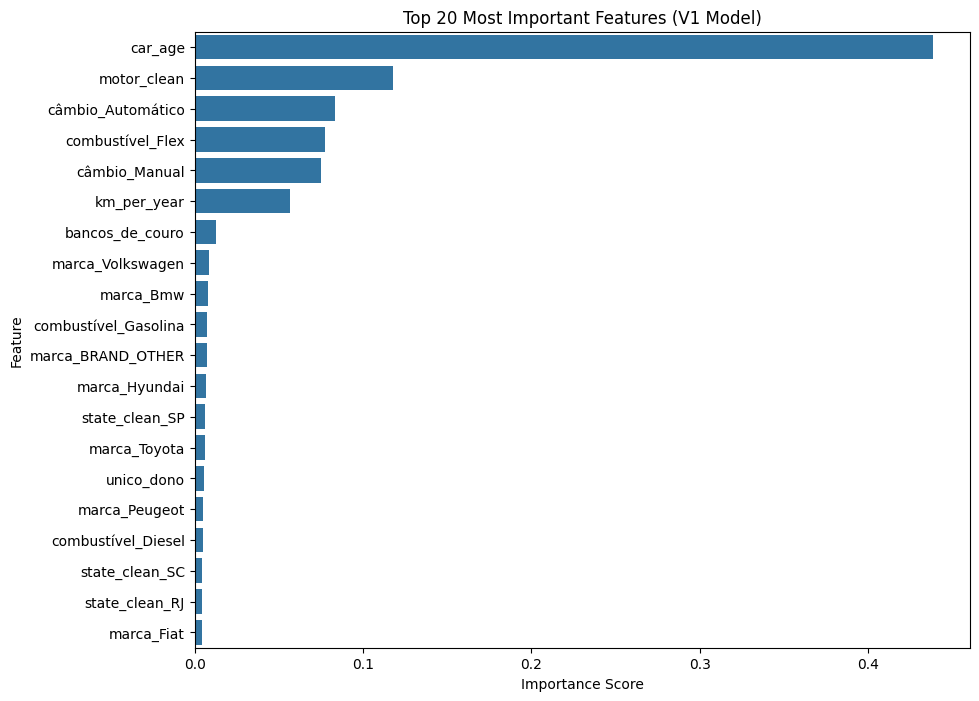

--- Top 10 Features ---
car_age                 0.438276
motor_clean             0.117898
câmbio_Automático       0.083223
combustível_Flex        0.077663
câmbio_Manual           0.074783
km_per_year             0.056635
bancos_de_couro         0.012819
marca_Volkswagen        0.008369
marca_Bmw               0.007994
combustível_Gasolina    0.007265
dtype: float64


In [10]:
# --- This is the complex part: Getting feature names from the pipeline ---

# 1. Get the trained 'preprocessor' and 'model'
preprocessor = model_pipeline.named_steps['preprocessor']
model = model_pipeline.named_steps['model']

# 2. Get the feature names from the OneHotEncoder
# This is how we get 'marca_VW', 'state_clean_SP', etc.
ohe_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

# 3. Get the original numeric and boolean feature names
# (which we defined in Célula 9)
numeric_features_list = numeric_features
boolean_features_list = boolean_features

# 4. Combine all feature names IN THE CORRECT ORDER
# (This must match the order in the ColumnTransformer)
all_feature_names = numeric_features_list + list(ohe_feature_names) + boolean_features_list

# --- Now the easy part: Create and Plot ---

# 1. Get the importance scores from the trained model
importances = model.feature_importances_

# 2. Create a pandas Series for easy plotting
feat_importance_series = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)

# 3. Plot the Top 20 most important features
plt.figure(figsize=(10, 8))
sns.barplot(
    x=feat_importance_series.head(20),
    y=feat_importance_series.head(20).index
)
plt.title('Top 20 Most Important Features (V1 Model)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

print("--- Top 10 Features ---")
print(feat_importance_series.head(10))

### "Where did you fail?" (Residual Analysis)

`feature_importance_` tells us what the model *used*. 
A **Residual Plot** tells us *where* the model *failed*.

A "residual" is simply the error ( `y_test - y_pred` ). We want to plot our predictions against our errors to see if there's a *pattern*.

* **A "good" plot:** A random cloud of dots. This means our errors are random, which is good.
* **A "bad" plot:** A funnel shape, a 'U' shape, or a clear line. This means our model makes *systematic* errors (e.g., it gets *worse* as the price gets *higher*).

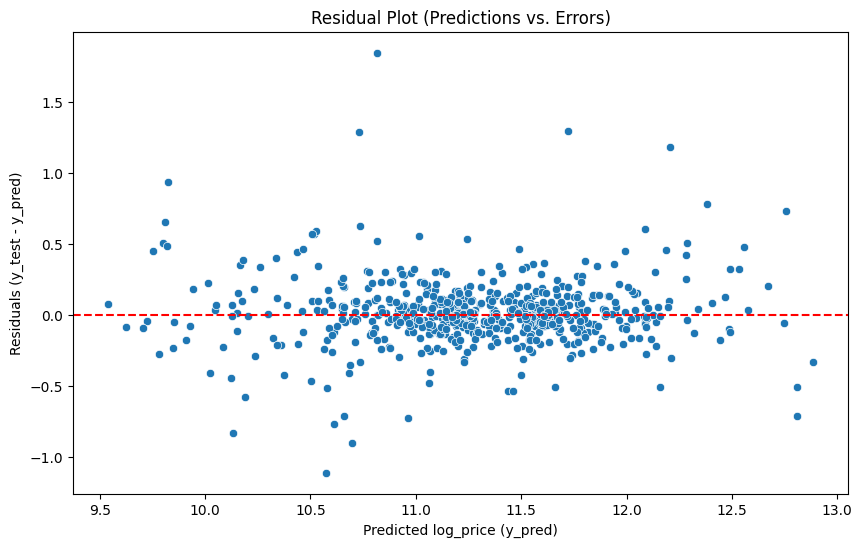

In [11]:
# 1. Calculate the errors (residuals)
residuals = y_test - y_pred

# 2. Create the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--') # Add a red line at y=0 (no error)
plt.title('Residual Plot (Predictions vs. Errors)')
plt.xlabel('Predicted log_price (y_pred)')
plt.ylabel('Residuals (y_test - y_pred)')
plt.show()

### Model V2 Experiment (Plan A: All Features)

Our V1 model (R² 0.85) was just a baseline. It intentionally ignored 40+ boolean "optional" columns (`ar_condicionado`, `alarme`, etc.).

In this experiment (V2), we will test **Hypothesis A:** "Adding all available boolean features will give the model more signals and increase its predictive power."

Let's build a new pipeline from scratch, this time using *every* feature we have.

In [12]:
# 1. Load the FULL clean dataset (not the V1 features)
df_v2 = pd.read_csv('../data/processed/olx_cars_cleaned.csv')

# 2. Re-run our Feature Engineering to create the core columns
# (This is the same code from Act 1, Célula 7)
CURRENT_YEAR = 2025
df_v2['log_price'] = np.log1p(df_v2['price_clean'])
df_v2['car_age'] = CURRENT_YEAR - df_v2['ano_limpo']
df_v2.loc[df_v2['car_age'] <= 0, 'car_age'] = 0.5
df_v2['quilometragem_clean'] = df_v2['quilometragem_clean'].fillna(0)
df_v2['km_per_year'] = df_v2['quilometragem_clean'] / df_v2['car_age']
df_v2['km_per_year'] = df_v2['km_per_year'].replace([np.inf, -np.inf], np.nan).fillna(0)

# 3. Tratamento da Cauda Longa (do feature_builder.py)
# Nós temos que fazer isso aqui agora, pois o arquivo limpo não tem
state_counts_v2 = df_v2['state_clean'].value_counts()
rare_states_v2 = state_counts_v2[state_counts_v2 < 50].index
df_v2['state_clean'] = df_v2['state_clean'].replace(rare_states_v2, 'STATE_OTHER')

brand_counts_v2 = df_v2['marca'].value_counts()
top_20_brands_v2 = brand_counts_v2.head(20).index
df_v2['marca'] = df_v2['marca'].apply(lambda x: x if x in top_20_brands_v2 else 'BRAND_OTHER')


print("V2 DataFrame loaded and engineered.")
print(f"Shape with ALL columns (approx): {df_v2.shape}")

V2 DataFrame loaded and engineered.
Shape with ALL columns (approx): (3375, 75)


In [13]:
# 1. Define new Target (y) and Features (X)
y_v2 = df_v2['log_price']

# We must drop ALL non-feature columns
# (O .select_dtypes('object') vai pegar 'marca', 'câmbio', etc., mas também lixo como 'url', 'title_list')
# Vamos ser explícitos e dropar o lixo que o ETL manteve
cols_to_drop = ['log_price', 'price_clean', 'url', 'title_list', 'description', 
                'color_list', 'modelo', 'city_clean', 'neighborhood_clean', 'ano_limpo'] 

# Filtra X_v2 para conter apenas colunas que existem no df_v2
valid_cols_to_drop = [col for col in cols_to_drop if col in df_v2.columns]
X_v2 = df_v2.drop(columns=valid_cols_to_drop)

print(f"V2 Features (X_v2) shape: {X_v2.shape}") # Deve ter 60+ colunas!

# 2. Split the V2 data
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(X_v2, y_v2, test_size=0.2, random_state=42)

print(f"V2 Train shape: {X_train_v2.shape}")

V2 Features (X_v2) shape: (3375, 65)
V2 Train shape: (2700, 65)


In [14]:
# --- 1. Identify ALL columns by type ---

# Mágica: Pede pro Pandas achar as colunas pra gente
numeric_features_v2 = X_train_v2.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features_v2 = X_train_v2.select_dtypes(include=['object']).columns.tolist()
boolean_features_v2 = X_train_v2.select_dtypes(include=['bool']).columns.tolist()

print(f"Found {len(numeric_features_v2)} numeric features.")
print(f"Found {len(categorical_features_v2)} categorical features.")
print(f"Found {len(boolean_features_v2)} boolean features (This should be 40+).")

# --- 2. Define the "recipes" (igual ao V1) ---
numeric_transformer_v2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])
categorical_transformer_v2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse=False é mais fácil de debugar
])

# --- 3. Create the V2 ColumnTransformer ("The Brain") ---
# A GRANDE DIFERENÇA: Agora estamos passando as listas COMPLETAS
preprocessor_v2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_v2, numeric_features_v2),
        ('cat', categorical_transformer_v2, categorical_features_v2),
        ('bool', 'passthrough', boolean_features_v2) # Deixa passar TODAS as booleanas
    ])

print("V2 Preprocessor (ColumnTransformer) created successfully.")

Found 9 numeric features.
Found 9 categorical features.
Found 47 boolean features (This should be 40+).
V2 Preprocessor (ColumnTransformer) created successfully.


In [15]:
# 1. Create the V2 pipeline
model_pipeline_v2 = Pipeline(steps=[
    ('preprocessor', preprocessor_v2), # O novo preprocessor V2
    ('model', RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ))
])

# 2. Train the V2 model
print("Training the V2 model (All Features)...")
model_pipeline_v2.fit(X_train_v2, y_train_v2)
print("V2 model training complete!")

# 3. Evaluate the V2 model
print("Evaluating V2 model on the test set...")
y_pred_v2 = model_pipeline_v2.predict(X_test_v2)

# 4. Calculate metrics
r2_v2 = r2_score(y_test_v2, y_pred_v2)
rmse_v2 = np.sqrt(mean_squared_error(y_test_v2, y_pred_v2))

print("\n--- MODEL COMPARISON ---")
print(f"V1 Score (Baseline, 12 features):   R² = {r2:.4f}  (RMSE = {rmse:.4f})")
print(f"V2 Score (All Features, {X_v2.shape[1]} features): R² = {r2_v2:.4f}  (RMSE = {rmse_v2:.4f})")

Training the V2 model (All Features)...
V2 model training complete!
Evaluating V2 model on the test set...

--- MODEL COMPARISON ---
V1 Score (Baseline, 12 features):   R² = 0.8493  (RMSE = 0.2291)
V2 Score (All Features, 65 features): R² = 0.8621  (RMSE = 0.2191)


### Model V3 Experiment (Plan C: The XGBoost "Cannon")

The V2 model (RandomForest, R² 0.86) is strong. But now we test **Hypothesis C:** "A more powerful algorithm can achieve a better score *using the exact same features*."

We will replace the `RandomForestRegressor` with an `XGBRegressor`, the "king of Kaggle" for tabular data. We will re-use our *identical* `preprocessor_v2` for a perfect 1:1 comparison.

In [16]:
# 1. Import the "Cannon"
# (Make sure you ran 'pip install xgboost' in your terminal first!)
from xgboost import XGBRegressor

# 2. Create the V3 pipeline
# Notice the *only* change is the 'model' step
model_pipeline_v3 = Pipeline(steps=[
    ('preprocessor', preprocessor_v2), # Re-using the V2 preprocessor
    ('model', XGBRegressor(
        n_estimators=100,        # 100 trees (good default)
        learning_rate=0.1,       # How fast the model learns (good default)
        random_state=42,
        n_jobs=-1
    ))
])

# 3. Train the V3 model
print("Training the V3 model (XGBoost, All Features)...")
# We use the *exact same* V2 training data
model_pipeline_v3.fit(X_train_v2, y_train_v2)
print("V3 model training complete!")

# 4. Evaluate the V3 model
print("Evaluating V3 model on the test set...")
y_pred_v3 = model_pipeline_v3.predict(X_test_v2)

# 5. Calculate metrics
r2_v3 = r2_score(y_test_v2, y_pred_v3)
rmse_v3 = np.sqrt(mean_squared_error(y_test_v2, y_pred_v3))

print("\n--- FINAL MODEL COMPARISON ---")
print(f"V1 (Baseline, 12 features):       R² = {r2:.4f}  (RMSE = {rmse:.4f})")
print(f"V2 (RandomForest, 65 features):   R² = {r2_v2:.4f}  (RMSE = {rmse_v2:.4f})")
print(f"V3 (XGBoost, 65 features):        R² = {r2_v3:.4f}  (RMSE = {rmse_v3:.4f})")

Training the V3 model (XGBoost, All Features)...
V3 model training complete!
Evaluating V3 model on the test set...

--- FINAL MODEL COMPARISON ---
V1 (Baseline, 12 features):       R² = 0.8493  (RMSE = 0.2291)
V2 (RandomForest, 65 features):   R² = 0.8621  (RMSE = 0.2191)
V3 (XGBoost, 65 features):        R² = 0.8731  (RMSE = 0.2102)


### Model V4 Experiment

We are at 87.3% R², tantalizingly close to 90%.

Our V3 model (XGBoost) is powerful, but it's running on "factory default" settings. We haven't tuned its hyperparameters.

We will now use **`RandomizedSearchCV`** to automatically test dozens of combinations of settings (`n_estimators`, `learning_rate`, `max_depth`) to "fine-tune" our cannon and squeeze out the last few percentage points of performance.

This... is going to take a while.

In [31]:
# 1. Import the "Tuner"
from sklearn.model_selection import RandomizedSearchCV

# 2. Define the "Search Space"
# These are the hyperparameters we want to tune for XGBoost.
# We must use the 'model__' prefix because we are tuning a *step* inside our pipeline.
param_dist = {
    'model__n_estimators': [100, 300, 500, 700, 1000],        # Number of trees
    'model__learning_rate': [0.01, 0.2, 0.05, 0.1, 0.2],         # How fast it learns
    'model__max_depth': [3, 5, 7, 9],                         # Max depth of each tree
    'model__subsample': [0.7, 0.8, 0.9, 1.0],                 # % of data per tree
    'model__colsample_bytree': [0.7, 0.8, 0.9, 1.0]           # % of features per tree
}

# 3. Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    model_pipeline_v3,      # Our V3 (XGBoost) pipeline
    param_distributions=param_dist,
    n_iter=500,
    cv=15,                   # 5-fold cross-validation
    scoring='r2',           # Our metric is R-squared
    n_jobs=-1,
    random_state=42,
    verbose=2               # Show me what you're doing
)


# 4. --- RUN THE TUNER ---
print("Starting Hyperparameter Tuning (V4)... This will take several minutes.")
random_search.fit(X_train_v2, y_train_v2) # Fitting on the V2 data
print("Tuning complete!")

# 5. --- THE RESULTS ---
print("\n--- Tuning Results ---")
print(f"Best R² score found during tuning: {random_search.best_score_:.4f}")
print("Best hyperparameters found:")
print(random_search.best_params_)

# 6. --- FINAL EVALUATION (V4) ---
print("\nEvaluating V4 (Tuned Model) on the test set...")
# 'best_estimator_' is the pipeline with the best settings found
best_model_v4 = random_search.best_estimator_
y_pred_v4 = best_model_v4.predict(X_test_v2)

# Calculate metrics
r2_v4 = r2_score(y_test_v2, y_pred_v4)
rmse_v4 = np.sqrt(mean_squared_error(y_test_v2, y_pred_v4))

Starting Hyperparameter Tuning (V4)... This will take several minutes.
Fitting 15 folds for each of 500 candidates, totalling 7500 fits
Tuning complete!

--- Tuning Results ---
Best R² score found during tuning: 0.8478
Best hyperparameters found:
{'model__subsample': 0.7, 'model__n_estimators': 1000, 'model__max_depth': 5, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.7}

Evaluating V4 (Tuned Model) on the test set...


In [ ]:
# 6. --- FINAL EVALUATION (V4) ---
best_model_v4 = random_search.best_estimator_

y_pred_v4 = best_model_v4.predict(X_test_v2)

# Calculate metrics
r2_v4 = r2_score(y_test_v2, y_pred_v4)
rmse_v4 = np.sqrt(mean_squared_error(y_test_v2, y_pred_v4))

# --- O GRAND FINALE (COM V4) ---
print("\n--- FINAL MODEL COMPARISON (ALL VERSIONS) ---")
print(f"V1 (Baseline, 12 feats):        R² = {r2:.4f}  (RMSE = {rmse:.4f})")
print(f"V2 (RandomForest, 65 feats):    R² = {r2_v2:.4f}  (RMSE = {rmse_v2:.4f})")
print(f"V3 (XGBoost, 65 feats):         R² = {r2_v3:.4f}  (RMSE = {rmse_v3:.4f})")
print(f"V4 (Tuned XGBoost, 65 feats):   R² = {r2_v4:.4f}  (RMSE = {rmse_v4:.4f})")


--- FINAL MODEL COMPARISON (ALL VERSIONS) ---
V1 (Baseline, 12 feats):        R² = 0.8493  (RMSE = 0.2291)
V2 (RandomForest, 65 feats):    R² = 0.8621  (RMSE = 0.2191)
V3 (XGBoost, 65 feats):         R² = 0.8731  (RMSE = 0.2102)
V4 (Tuned XGBoost, 65 feats):   R² = 0.8829  (RMSE = 0.2019)
